
# Notebook 2: EDA, DataCleanup, Feature Engineering, and Model Development

Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

## Summary: ##    
In this notebook I read and explore the data set deeply to establish a strategy for my feature engineering. This is a continuation from my initial baseline notebook where i did a soft EDA, mainly addressing null values, then running a basic linear regression to predict the 'SalesPrice' from the test training set. Below is an outline summarizing the two main parts of this notebook

**Pt.1 Reading the dataset**
The data set included from Kaggle includes a training.csv (1460x81) and a test.csv file (1459x80). The data types include floats (3), integers(35) and categorical objects (43). 

**Pt.2 Missing Data**
The majority of the NA/missing data is observed within the object data type. It's my assumption that most of these are a mix of Nominal data where the entries carry no numerical value and Oridinal which do (i.e OverallQuality)

**Pt.3 Data Visualization** 

<u>*a.Sales Price Distribution*</u> To visualize the sales data i created a distribution plot and a box-plot. The distribution plot displays a a semi-bell shape which is slightly skewed to the right, indicating that the data follows a normal distribution which should work well with machine learning models. The box plot shows that there are some outliers in the data which I may consider removing from the training data set.
 
<u>*a.Correlation Heatmap*</u> I executed a correlation matrix with the training data set and the features that demonstrated the highest correlation to Saleprice is  ['GrLivArea','OverallQual', '1stFlrSF', 'GarageCars']  

<u>*b.Pairwise Plots:*</u> I executed a pairwise plot utilizing the features with the highest correlation to sales price to gather additional insight. The output of the Pairwise plot included histograms, and scatter plots. Each histogram resembles a bell shape of some sort which is indicative of a normal distribution. Each scatter plot displayed a positive increase directionally. 

<u>*c.Linear regression Plot:*</u> GrLivArea(X), with SalesPrice(Y). We noticed two data outliers where an extremely high Ground Living Area resulted to an extremely low sales price. This is something I'll consider addressing when doing feature engineering. 

<u>*d.Plotting OverallQual with Sales Price:*</u> We observe a positive with an increase which makes a lot of sense
Since this feature is ordinal, I will utilize dummy variables encoding during the feature engineering

**Pt.4 Data Cleaning and Data engineering**  

    a. handling missing values  
    b. handling missing values   


**Pt.5 Regression Modelling** 

     a.Lasso  
        b.RandomForestRegressor  
        c.ElasticNet  
        d.KernelRidge  
        e.GradientBoostingRegressor



In [1]:
#pip install xgboost

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
from IPython import display

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

# Import MLlibraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from sklearn.utils import shuffle

from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC

#used as arguments to bold face displayed outputs
start = "\033[1m"
end = "\033[0;0m"

## Pt. 1 Read the Data Set
- create train_data and test_data objects
- checking the shape, features, and data types
- are there any null values?

In [3]:
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
train_data.shape

(1460, 81)

In [5]:
test_data.shape

(1459, 80)

In [6]:
#what are the data types?
dtype = train_data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


In [7]:
#display head
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
#Removing the id column since it doesnt help the prediction. 
#However id column is required in order to submit a prediction
# store id
id_train= train_data['Id']
Id_test = test_data['Id']

train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

## Pt.2 Missing Values

### Missing int64

In [9]:
##Looking at any missing values from the int dtypes
int_features= train_data.select_dtypes(include="int64")
int_features.columns

print("--Missing int64 entries--")
missing_percent = pd.DataFrame(int_features.isna().mean(axis=0)*100, columns=["Missing %"])
total_missing = pd.DataFrame(int_features.isna().sum(axis=0),columns=["Total Missing"])
int_misstable = pd.concat([missing_percent,total_missing],axis = 1)
int_misstable.loc[int_misstable['Total Missing'] > 0,:].sort_values(by = "Missing %", ascending = False)

--Missing int64 entries--


,Missing %,Total Missing


### Missing Object dtypes

In [10]:
cat_features= train_data.select_dtypes(include="object")
print(start+"--Missing categorical entries--"+end)
missing_percent = pd.DataFrame(cat_features.isna().mean(axis=0)*100, columns=["Missing %"])
total_missing = pd.DataFrame(cat_features.isna().sum(axis=0),columns=["Total Missing"])
cat_misstable = pd.concat([missing_percent,total_missing],axis = 1)
cat_misstable.loc[cat_misstable['Total Missing'] > 0,:].sort_values(by = "Missing %", ascending = False)


--Missing categorical entries--


,Missing %,Total Missing
PoolQC,99.520548,1453
MiscFeature,96.301370,1406
Alley,93.767123,1369
Fence,80.753425,1179
FireplaceQu,47.260274,690
GarageType,5.547945,81
GarageFinish,5.547945,81
GarageQual,5.547945,81
GarageCond,5.547945,81
BsmtExposure,2.602740,38


In [11]:
float_features= train_data.select_dtypes(include="float")
print(start+"--Missing float entries--"+end)
missing_percent = pd.DataFrame(float_features.isna().mean(axis=0)*100, columns=["Missing %"])
total_missing = pd.DataFrame(float_features.isna().sum(axis=0),columns=["Total Missing"])
float_misstable = pd.concat([missing_percent,total_missing],axis = 1)
float_misstable.loc[float_misstable['Total Missing'] > 0,:].sort_values(by = "Missing %", ascending = False)

--Missing float entries--


,Missing %,Total Missing
LotFrontage,17.739726,259
GarageYrBlt,5.547945,81
MasVnrArea,0.547945,8


## Statististical Summary

In [12]:

def summary(numerical_data):
    print('\n Statistical Summary of categorical data:\n',numerical_data.describe(include=np.object))
    print('\n Statistical Summary of float data:\n', numerical_data.describe(include=np.float))
    print('\n Statistical Summary of float data:\n', numerical_data.describe(include=np.int64))
      
summary(train_data)



 Statistical Summary of categorical data:
        MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1379         1379   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        870          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1379       1379       1460      7    281          54     1460   
unique          5          5          3      3      4           4   

## Visualizing the Data

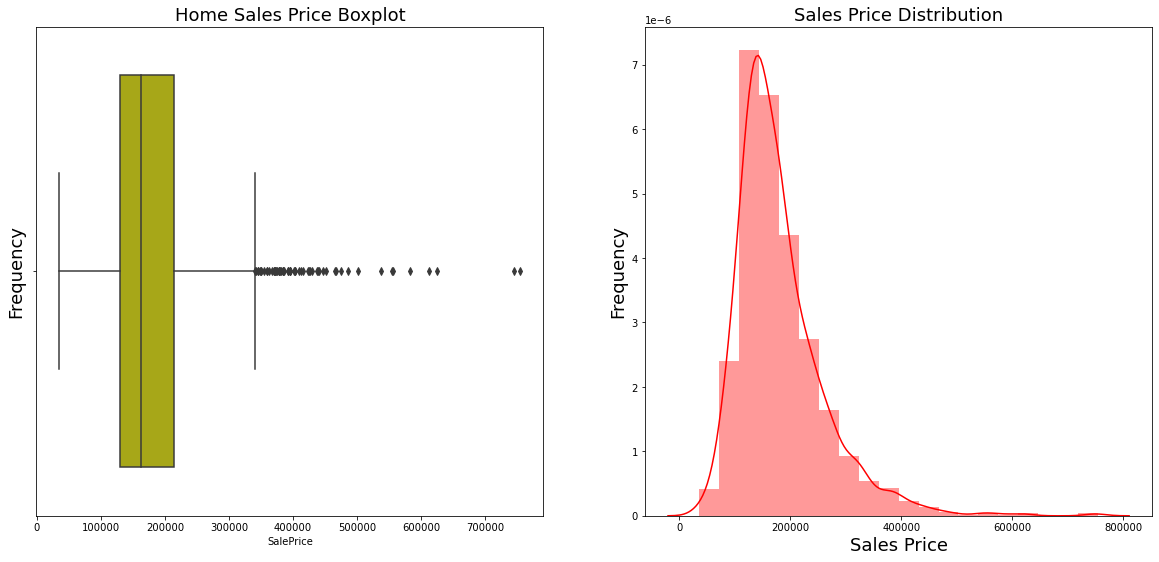

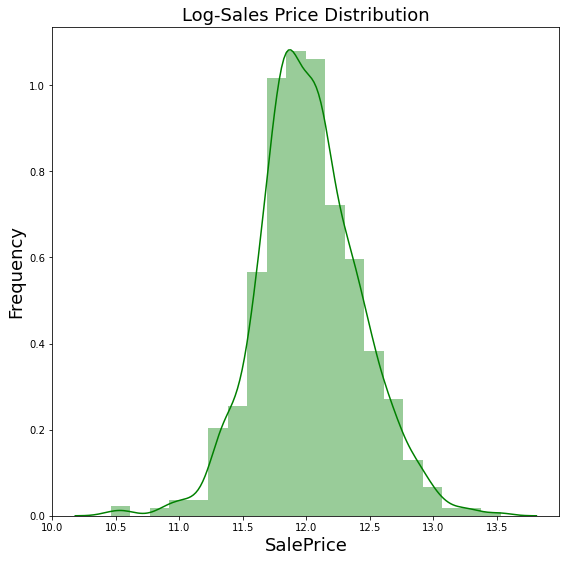

In [13]:
# Function to visualize the target variable
def plot_SalesPrice(train_data):
    plt.figure(figsize=(20,9))
    plt.subplot(1,2,1)
    plt.title('Home Sales Price Boxplot', fontsize= 18)
    plt.ylabel("Frequency", fontsize= 18)
    sns.boxplot(x= train_data.SalePrice, color = 'y')

    plt.subplot(1,2,2)
    plt.title('Sales Price Distribution',fontsize= 18)
    plt.ylabel("Frequency", fontsize= 18)
    plt.xlabel("Sales Price", fontsize = 18)
    sns.distplot(x=train_data.SalePrice, bins=20, color="r")
    plt.show()

def plot_log_SalePrice(train_data):
    plt.figure(figsize=(20,9))
    plt.subplot(1,2,2)
    plt.title('Log-Sales Price Distribution',fontsize= 18)
    plt.ylabel("Frequency", fontsize= 18)
    plt.xlabel("Sales Price", fontsize = 18)
    sns.distplot(train_data.SalePrice, bins=20, color="g")
    plt.show()
    
plot_SalesPrice(train_data)

# Log transformation
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
plot_log_SalePrice(train_data)

 -The Box Plot on the top left shows that there are clear outliers in the Sales Price Data. 
 -The Distribution Plot of the top right shows a a semi-normal distribution with a right tail. 
 -Taking the Log of the Distribution plot we were able to normalize the data and now we see a clear bell shaped curve. 
 
 **Because this is a normal distribution, the data lends itself well to machine learning** 
 
 The distribution plot displays a a semi-bell shape which is slightly skewed to the right, indicating that the data follows a normal distribution which should work well with machine learning models. The box plot shows that there are some outliers in the data which I may consider removing from the training data set.


### **Cleaning Step 1:**  
-1. Normalizing the Sales data by getting the natural log  
-2. Removing Outliers in SalesPrice

In [14]:
# Removing the outliers from sales data
train_data =train_data[train_data['SalePrice']<700000]

### log Trainsformation

In [15]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

**Concatinating the training and test data sets for easy data cleaning**

In [16]:
## Merdging Train Data and Test Data
train_len = len(train_data) # created length of the train data so that after EDA is done we can seperate the train and test data
combined_data = pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)

In [17]:
print("original train_data shape", train_data.shape)
print("combined data shape= ", combined_data.shape)

original train_data shape (1460, 80)
combined data shape=  (2919, 80)


In [18]:
# A function for calculating the missing data
def missing_data(df):
    tot_missing=df.isnull().sum().sort_values(ascending=False)
    Percentage=tot_missing/len(df)*100
    missing_data=pd.DataFrame({'Missing Percentage': Percentage})
    
    return missing_data.head(36)

missing_data(combined_data)

,Missing Percentage
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071


**The above mentioned columns have missing value. There are different ways of imputing missing values. From our observation we can replace categorical features with None and numerical features with 0.**

## Cleaning Step 2:  
filling objects with "None" and numerical features with "0"

In [19]:
# Features with missing value
miss_col1=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageYrBlt',
           'GarageFinish', 'GarageQual', 'BsmtExposure','BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 
           'MasVnrArea', 'MasVnrType','SaleType','MSZoning','Utilities','Functional','Exterior1st','Exterior2nd',
           'BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','GarageArea','KitchenQual','GarageCars','BsmtFullBath',
           'BsmtHalfBath','BsmtUnfSF']
# Imputing missing value
for col in miss_col1:
    if combined_data[col].dtype=='object':
        combined_data[col]=combined_data[col].fillna("None")
    else:
        combined_data[col]=combined_data[col].fillna(0)

### Handling Missing Values for "Lot Frontage" and "Electrical"

**'LotFrontage'**- by definition is the boudary in front of the plot adjacent to the home. I think it would be a safe assumption to use the median value of the neighborhood to fill in these missing values

In [20]:
# Imputing missing value with neighborhood value
combined_data['LotFrontage']=combined_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

<img src="images/landLot.png" width="400" height="200">

**'Electrical'**- Describes the electrical system in the house. There are 5 features where 3 of them are ranked from poor to average wheras the other two dont provide any context on how they rank out of the three. So in this instance i will just treat it as a categorical and fill the missing values with the mode

<img src="images/electrical.png" width="800" height="400">

In [21]:
# Imputing missing value with mode-most occuring no
combined_data['Electrical']=combined_data['Electrical'].fillna(combined_data['Electrical'].mode()[0])

### Correlation Matrix of Data Featuers
- What features have the largest correltionship with the sales price?

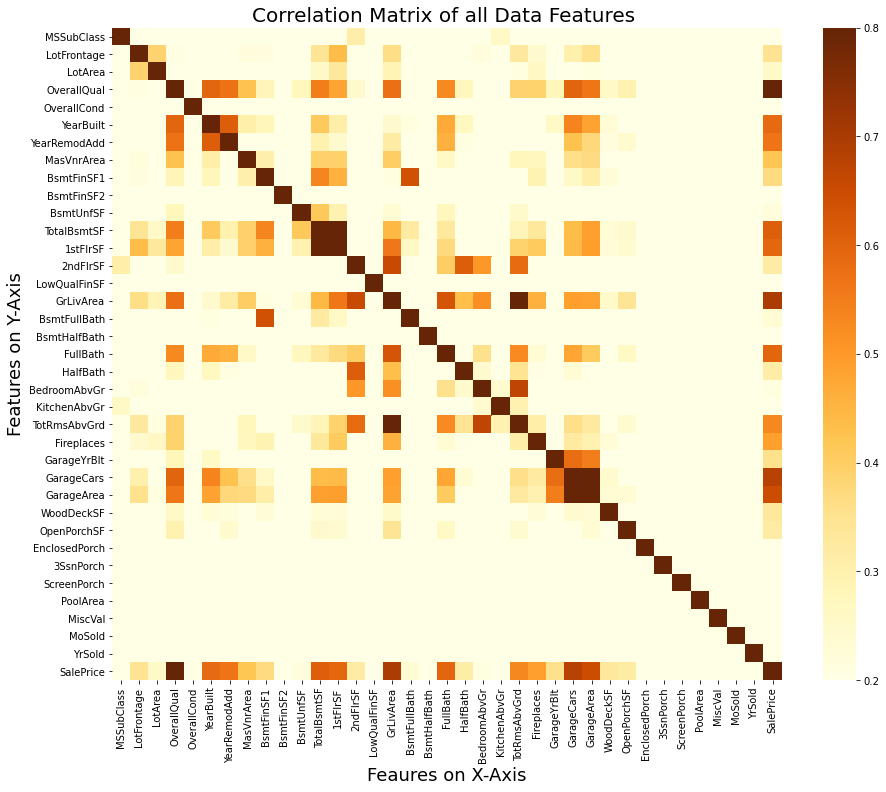

In [22]:
plt.subplots(figsize=(15, 12))
sns.heatmap(combined_data.corr(), vmin=0.2, vmax=0.8, cmap = "YlOrBr")

plt.xlabel('Feaures on X-Axis',fontsize= 18)
plt.ylabel('Features on Y-Axis',fontsize= 18)
plt.title('Correlation Matrix of all Data Features ', fontsize= 20);


**Independent Features with strong correlation to SalePrice:**  
-The features with the highest correlation(darkest squares) include "OverallQual" and "GrLivArea".   
-The features with a medium-high correlation(medium-dark squares) include "1stFlrSF", and "GarageCars".

**Feature Colinearity:**   
Based on the heatmap, we see that there are features that share strong correlationships:  
-- YearBuilt / GarageYrBlt  
-- TotalBsmtSF / 1stFirSF  
-- GarageCar / GarageArea

To Address this issue, we will have to do some feature engineering. 


###  Plotting Pairwise relationship between SalePrice GrLivArea, OverallQual
-# plot dependent variable, sales prices to see how it's distributed. Then plot correlations w. highly correlated variables


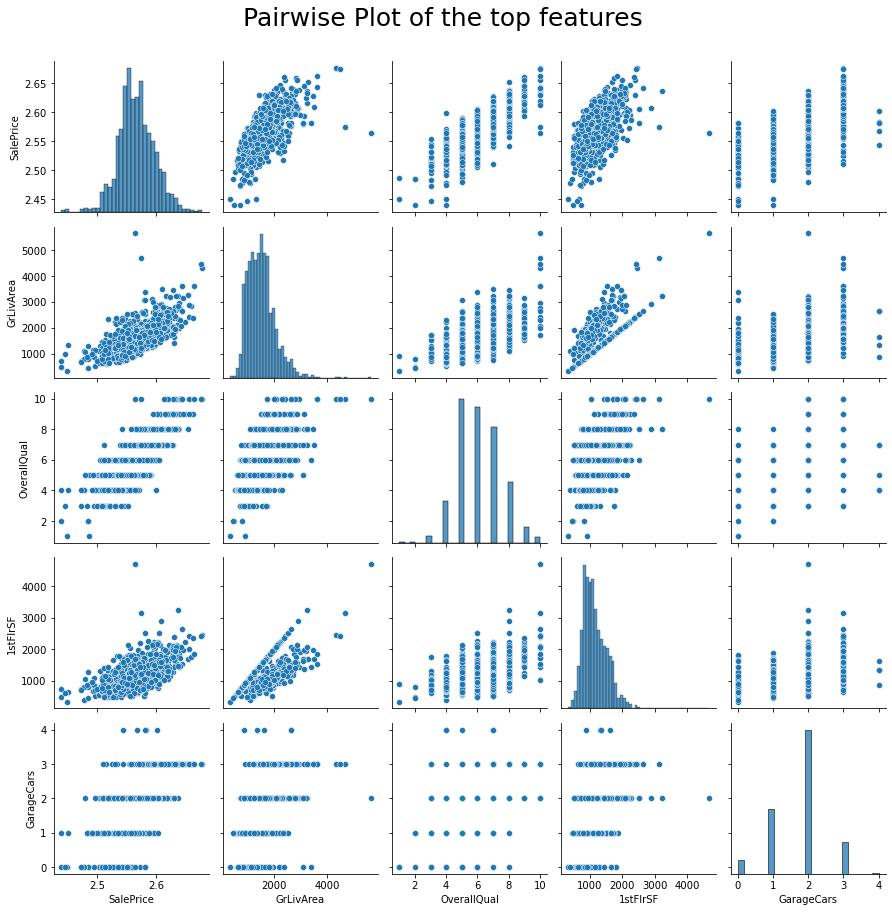

In [23]:
#Scatter plot of thr most important features
highest_corr = ['SalePrice','GrLivArea','OverallQual', '1stFlrSF', 'GarageCars']
sns.pairplot(train_data[highest_corr])
plt.suptitle('Pairwise Plot of the top features ',x=0.5, y=1.01, verticalalignment='top', fontsize= 25)
plt.tight_layout()
plt.show();

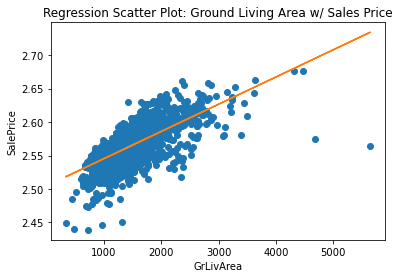

In [24]:
#Plotting Ground Living Area with Sales Price wiht a linear regression line
x=train_data['GrLivArea']
y=train_data['SalePrice']

plt.plot(x, y, 'o')
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b)

plt.ylabel('SalePrice', fontsize= 10)
plt.xlabel('GrLivArea', fontsize= 10)
plt.title('Regression Scatter Plot: Ground Living Area w/ Sales Price', fontsize= 12)
plt.show();

**notes**   
-Looking closely at the relationship between the size of the ground living area and sale price we notice two outliers. It doesn't make sense for the two houses with the largest ground living area to have the cheapest sales price. There needs to be some additional digging
To address this during feature engineering, we can set a threshold to remove them so it doesn't interfear with the prediction algorithm. 

In [25]:
#remove outliers from groud living area
train_data =train_data[train_data['GrLivArea']<4600]

## Create Feature Total Area

Since square feet is an obvious contributer to overall price of the home, we can combine the features and create a Total Square feet feature "TotalSF". 

In [27]:
combined_data['TotalSF']= combined_data['TotalBsmtSF']+ combined_data['1stFlrSF']+combined_data['2ndFlrSF']+combined_data['GarageArea']+combined_data['GrLivArea']

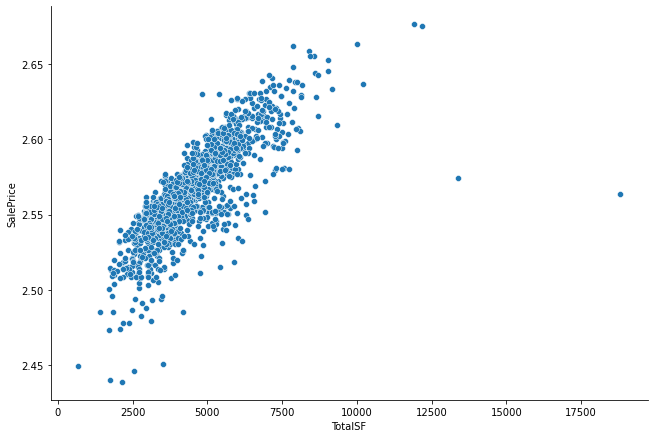

In [28]:
sns.relplot(data = combined_data, y="SalePrice", x='TotalSF', height=6, aspect=1.5)

## Convert Categorical Values to Numeric  

Some of the columns are numerical but they are actually categorical. They are 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold'. These columns are converted into categorical columns.


In [52]:
#from IPython import display

MSS = display.Image("images/MSSubclass.png")
year = display.Image("images/yearSold.png")

print(MSS, year)

<IPython.core.display.Image object> <IPython.core.display.Image object>


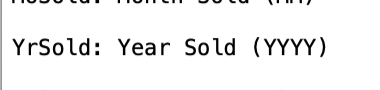

In [47]:
display.Image("images/yearSold.png")

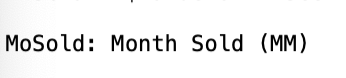

In [49]:
display.Image("images/MonthSold.png")

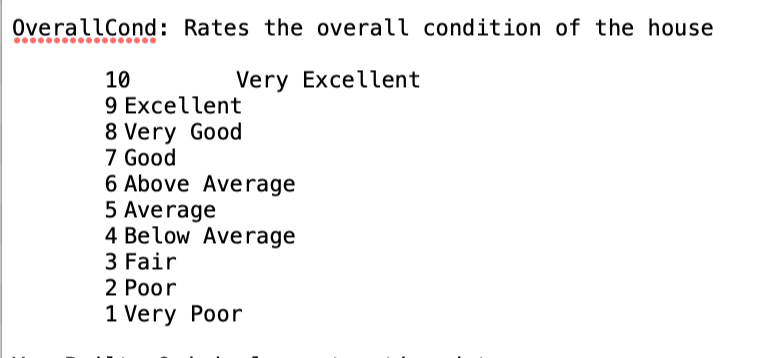

In [50]:
display.Image("images/OverallCondition.png")

In [29]:
cols=['MSSubClass','OverallCond','YrSold','MoSold']

for col in cols:
    combined_data[col] = combined_data[col].apply(str)

Converting categorical data to numerical data Some features are ordinal and some of them are nominal. For ordinal data let's do the label encoding and for nominal data i will do one hot encoding.



## Label Encoding For Ordinals
-Converting categorical data to numerical data
-For ordinal data let's do the label encoding and for nominal data i will do one hot encoding.

In [30]:
## Handling Ordinal Data
from sklearn.preprocessing import LabelEncoder
label_encode=LabelEncoder()

In [31]:
ordinal_cat=['OverallCond','KitchenQual','YrSold','MoSold','Fence','PoolQC','FireplaceQu','GarageQual', 
             'GarageCond','LotShape','LandSlope','HouseStyle','ExterQual','ExterCond','BsmtQual', 
             'BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC','KitchenQual','CentralAir',
             'MSSubClass']

for col in ordinal_cat:
    combined_data[col]=label_encode.fit_transform(combined_data[col])

In [32]:
# One hot encoding for nominal data
combined_data=pd.get_dummies(combined_data)

In [33]:
#Separating target and features

df_target= combined_data['SalePrice']
df_features= combined_data.drop(columns=['SalePrice'])

Data Preparation



In [34]:
X_train=df_features[:train_len]
Y_train=df_target[:train_len]
X_test=df_features[train_len:]

In [35]:
X_train.shape,Y_train.shape, X_test.shape


((1460, 236), (1460,), (1459, 236))

Data is ready for modeling

# Developing the best regression model for the prediction

In [36]:
# Collect the Results for the best model
Basic_model=[
    Lasso(),
    RandomForestRegressor(),
    ElasticNet(),
    KernelRidge(),
    GradientBoostingRegressor()
]

## Calculating RMSE

root mean squared error

In [37]:
# Function to calculate root mean squared error with default parameters
n_folds = 5 # five fold cross validation
def rmse_cv(models):
    
    model_name=[]
    RMSE=[]
    
    for model in models:
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
        rmse= np.sqrt(-cross_val_score(model, 
                                       X_train, Y_train, 
                                       scoring="neg_mean_squared_error", 
                                       cv = kf))
        mean_RMSE=np.mean(rmse)
        
        model_name.append(model.__class__.__name__)
        RMSE.append(mean_RMSE)
    
    result=pd.DataFrame({'Model':model_name,'RMSE':RMSE})
    
    result=result.sort_values(by='RMSE',ascending=True).reset_index()
    print("\nResult:\n", result)
    
    min_RMSE=min(result['RMSE'])
    best_model=result['Model'][0]# first row and first column
    
    print('The minimum RMSE is {} and the best model is {}'.format(min_RMSE,best_model))
        
rmse_cv(Basic_model)


Result:
    index                      Model      RMSE
0      4  GradientBoostingRegressor  0.009608
1      1      RandomForestRegressor  0.010724
2      3                KernelRidge  0.014663
3      2                 ElasticNet  0.017998
4      0                      Lasso  0.018281
The minimum RMSE is 0.009607787327572415 and the best model is GradientBoostingRegressor


## Using GridSearchCV to find the best estimator

In [38]:
# Grid search Cv method to find the best parameters

Lasso_params = {'alpha': [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006]}
RandomForest_params = {'n_estimators': list(range(50, 200, 25)), 'max_features': ['auto', 'sqrt', 'log2'], 
         'min_samples_leaf': list(range(50, 200, 50))}
ElasticNet_params = {'alpha': [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006]}
Ridge_params = {'alpha': [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006]}
Grad_boosting_params = {'n_estimators': [1000,2000,3000,4000,5000,6000]}

# Grid Search for Lasso 
grid_search_cv = GridSearchCV(Lasso(random_state=42), Lasso_params, n_jobs=-1)
grid_search_cv.fit(X_train, Y_train)

print(start+'Lasso:'+end, grid_search_cv.best_estimator_)

# Grid Search for RandomForest

grid_search_cv = GridSearchCV(RandomForestRegressor(random_state=42), RandomForest_params, n_jobs=-1)
grid_search_cv.fit(X_train, Y_train)

print(start+'RandomForest:'+end, grid_search_cv.best_estimator_)

# Grid Search for ElasticNet
grid_search_cv = GridSearchCV(ElasticNet(random_state=42), ElasticNet_params, n_jobs=-1)
grid_search_cv.fit(X_train, Y_train)

print(start+'ElasticNet:'+end, grid_search_cv.best_estimator_)

# Grid Search for KernelRidge
grid_search_cv = GridSearchCV(KernelRidge(), Ridge_params, n_jobs=-1)
grid_search_cv.fit(X_train, Y_train)

print(start+'KernelRidge:'+end, grid_search_cv.best_estimator_)

# Grid Search for GradientBoosting Regressor
grid_search_cv = GridSearchCV(GradientBoostingRegressor(), Grad_boosting_params, n_jobs=-1)
grid_search_cv.fit(X_train, Y_train)

print(start+'GradientBoostingRegressor:'+end, grid_search_cv.best_estimator_)

Lasso: Lasso(alpha=0.0001, random_state=42)
RandomForest: RandomForestRegressor(min_samples_leaf=50, n_estimators=175, random_state=42)
ElasticNet: ElasticNet(alpha=0.0001, random_state=42)
KernelRidge: KernelRidge(alpha=0.0001)
GradientBoostingRegressor: GradientBoostingRegressor(n_estimators=5000)


# RMSE with best parameters

In [39]:
# Function to calculate root mean squared error with best parameters
model_best_params=[
    Lasso(alpha =0.0001,random_state=42),
    RandomForestRegressor(min_samples_leaf=50,
                          n_estimators=175,
                          random_state=42),
    ElasticNet(alpha=0.0006,  random_state=42),
    KernelRidge(alpha=0.0001),
    GradientBoostingRegressor(n_estimators=1000)]

def rmse_cv(models):
    
    model_name=[]
    RMSE=[]
    for model in models:
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
        rmse= np.sqrt(-cross_val_score(model, X_train, Y_train,
                                       scoring="neg_mean_squared_error", cv = kf))
        mean_RMSE=np.mean(rmse)
        model_name.append(model.__class__.__name__)
        RMSE.append(mean_RMSE)
    
    result=pd.DataFrame({'Model':model_name,'RMSE':RMSE})
    
    result=result.sort_values(by='RMSE',ascending=True).reset_index()
    print("\nResult:\n", result)
    
    min_RMSE=min(result['RMSE'])
    best_model=result['Model'][0]# first row and first column
    
#     print('The best model and RMSE:  for best parameter are {} and {}'.format(best_model, min_RMSE))
    print('Best Model: {}'.format(best_model))
    print('RMSE: {}'.format(min_RMSE))
    
rmse_cv(model_best_params)


Result:
    index                      Model      RMSE
0      4  GradientBoostingRegressor  0.009445
1      0                      Lasso  0.011012
2      2                 ElasticNet  0.011773
3      1      RandomForestRegressor  0.013508
4      3                KernelRidge  0.017820
Best Model: GradientBoostingRegressor
RMSE: 0.009445067741150906


In [40]:
gbr_fit = GradientBoostingRegressor(alpha=0.9, n_estimators=5000).fit(X_train,Y_train)

y_pred= np.expm1(gbr_fit.predict(X_test))
test_prediction = pd.Series(y_pred, name="SalePrice")

Final_prediction= pd.concat([Id_test,test_prediction],axis=1)
Final_prediction.to_csv("data/test_score.csv", index=False)

## Updated Kaggle Score
<img src="images/updated_score.png" width="1000" height="800">

